<a href="https://colab.research.google.com/github/Shahilasulthana/DeepLearning/blob/main/Customer_Churn_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install kagglehub

In [2]:
import kagglehub

In [3]:

path = kagglehub.dataset_download("blastchar/telco-customer-churn")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'telco-customer-churn' dataset.
Path to dataset files: /kaggle/input/telco-customer-churn


In [4]:
import os
os.listdir(path)

['WA_Fn-UseC_-Telco-Customer-Churn.csv']

In [5]:
import pandas as pd
df = pd.read_csv(path + '/WA_Fn-UseC_-Telco-Customer-Churn.csv')

In [6]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


Dataset download has been completed, the dataset is directly imported from kaggle

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import warnings
warnings.filterwarnings('ignore')

In [8]:
np.random.seed(42)
tf.random.set_seed(42)

In [9]:
print(df.shape)

(7043, 21)


In [10]:
print(df.head)

<bound method NDFrame.head of       customerID  gender  SeniorCitizen Partner Dependents  tenure  \
0     7590-VHVEG  Female              0     Yes         No       1   
1     5575-GNVDE    Male              0      No         No      34   
2     3668-QPYBK    Male              0      No         No       2   
3     7795-CFOCW    Male              0      No         No      45   
4     9237-HQITU  Female              0      No         No       2   
...          ...     ...            ...     ...        ...     ...   
7038  6840-RESVB    Male              0     Yes        Yes      24   
7039  2234-XADUH  Female              0     Yes        Yes      72   
7040  4801-JZAZL  Female              0     Yes        Yes      11   
7041  8361-LTMKD    Male              1     Yes         No       4   
7042  3186-AJIEK    Male              0      No         No      66   

     PhoneService     MultipleLines InternetService OnlineSecurity  ...  \
0              No  No phone service             DSL   

Categorical columns: 15
Numerical columns: 4

Top 10 features correlated with Churn:
Churn               1.000000
MonthlyCharges      0.193356
PaperlessBilling    0.191825
SeniorCitizen       0.150889
PaymentMethod       0.107062
MultipleLines       0.038037
PhoneService        0.011942
gender             -0.008612
StreamingTV        -0.036581
StreamingMovies    -0.038492
Name: Churn, dtype: float64


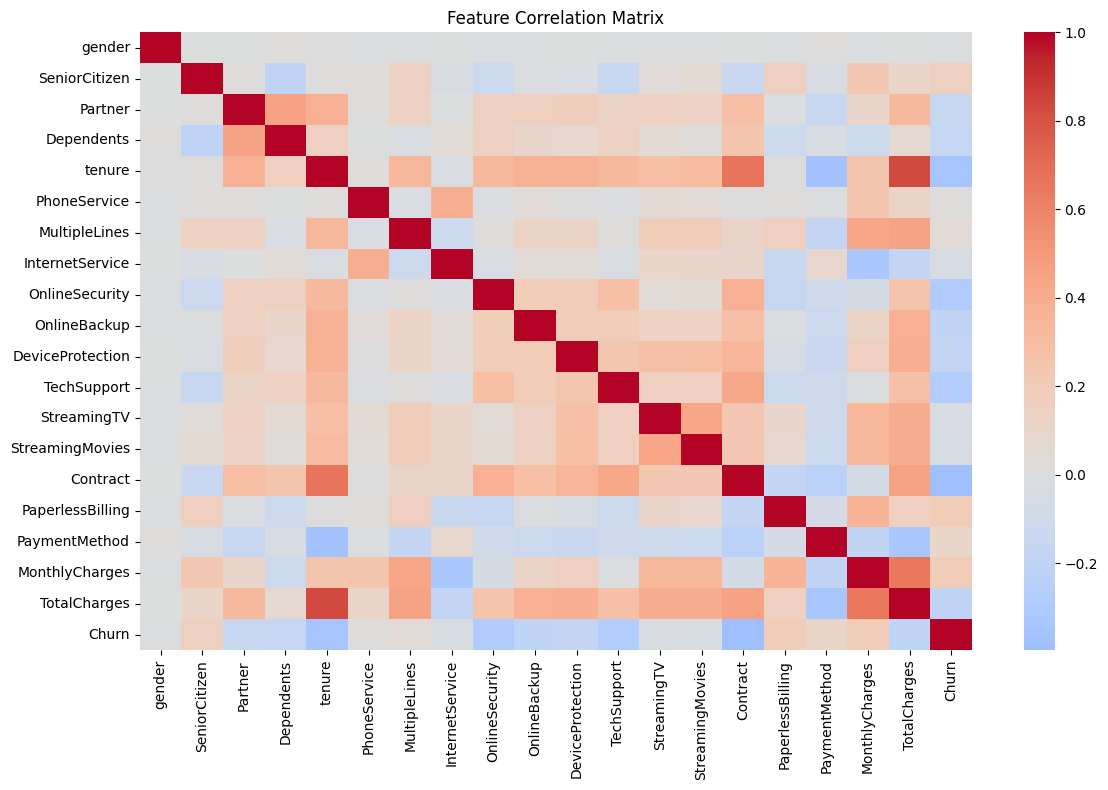

In [11]:
def preprocess_data(df):

    df_processed = df.copy()
    df_processed['TotalCharges'] = pd.to_numeric(df_processed['TotalCharges'], errors='coerce')
    df_processed['TotalCharges'].fillna(df_processed['TotalCharges'].median(), inplace=True) #fill missing valueis
    df_processed['Churn'] = df_processed['Churn'].map({'Yes': 1, 'No': 0})
    df_processed = df_processed.drop('customerID', axis=1)
    categorical_cols = df_processed.select_dtypes(include=['object']).columns
    numerical_cols = df_processed.select_dtypes(include=['int64', 'float64']).columns
    numerical_cols = numerical_cols.drop('Churn')  # Remove target from numerical

    print(f"Categorical columns: {len(categorical_cols)}")
    print(f"Numerical columns: {len(numerical_cols)}")

    # Label encode categorical variables
    label_encoders = {}
    for col in categorical_cols:
        le = LabelEncoder()
        df_processed[col] = le.fit_transform(df_processed[col])
        label_encoders[col] = le

    return df_processed, label_encoders, categorical_cols, numerical_cols

# Apply preprocessing
df_processed, label_encoders, cat_cols, num_cols = preprocess_data(df)

# ============================
# 4. FEATURE SELECTION & ENGINEERING
# ============================
# Check correlation with target
correlation_matrix = df_processed.corr()
churn_correlation = correlation_matrix['Churn'].sort_values(ascending=False)

print("\nTop 10 features correlated with Churn:")
print(churn_correlation.head(10))

# Visualize correlations
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', center=0)
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()

# Select features (you can adjust this based on correlation analysis)
# For this example, we'll use all features except highly correlated ones
X = df_processed.drop('Churn', axis=1)
y = df_processed['Churn']


In [12]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=42, stratify=y)

print(f"\nTraining set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")
print(f"\nChurn distribution in training set: {y_train.value_counts(normalize=True).values}")
print(f"Churn distribution in test set: {y_test.value_counts(normalize=True).values}")


Training set size: (5634, 19)
Test set size: (1409, 19)

Churn distribution in training set: [0.73464679 0.26535321]
Churn distribution in test set: [0.73456352 0.26543648]


In [13]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [14]:
def create_ann_model(input_dim):
    model = Sequential([
        Dense(128, activation='relu', input_dim=input_dim),
        BatchNormalization(),
        Dropout(0.3),

        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),

        Dense(32, activation='relu'),
        BatchNormalization(),
        Dropout(0.2),

        Dense(1, activation='sigmoid')
    ])
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy',
                 keras.metrics.Precision(name='precision'),
                 keras.metrics.Recall(name='recall'),
                 keras.metrics.AUC(name='auc')]
    )

    return model

In [15]:
input_dim = X_train_scaled.shape[1]
model = create_ann_model(input_dim)

print("\nModel Summary:")
model.summary()



Model Summary:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         2,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,825 (54.00 KB)

 Trainable params: 13,377 (52.25 KB)

 Non-trainable params: 448 (1.75 KB)

In [19]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=30,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=0.00001,
    verbose=1
)

# Train the model
history = model.fit(
    X_train_scaled, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Epoch 1/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.8011 - auc: 0.8477 - loss: 0.4146 - precision: 0.6496 - recall: 0.5244 - val_accuracy: 0.7924 - val_auc: 0.8210 - val_loss: 0.4401 - val_precision: 0.6276 - val_recall: 0.5085 - learning_rate: 1.2500e-04
Epoch 2/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.7939 - auc: 0.8450 - loss: 0.4163 - precision: 0.6319 - recall: 0.5122 - val_accuracy: 0.7950 - val_auc: 0.8221 - val_loss: 0.4399 - val_precision: 0.6333 - val_recall: 0.5153 - learning_rate: 1.2500e-04
Epoch 3/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7975 - auc: 0.8408 - loss: 0.4212 - precision: 0.6419 - recall: 0.5160 - val_accuracy: 0.7924 - val_auc: 0.8227 - val_loss: 0.4386 - val_precision: 0.6287 - val_recall: 0.5051 - learning_rate: 1.2500e-04
Epoch 4/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8023 - auc: 0.8408 - loss: 0.4226 - precision: 0.6537 - recall: 0.5238 - val_accuracy: 0.7941 - val_auc: 0.8230 - val_loss

In [ ]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=0.00001,
    verbose=1
)

# Train the model
history = model.fit(
    X_train_scaled, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

# ============================
# 8. EVALUATE THE MODEL
# ============================
# Plot training history
def plot_training_history(history):
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))

    # Accuracy
    axes[0, 0].plot(history.history['accuracy'], label='Train Accuracy')
    axes[0, 0].plot(history.history['val_accuracy'], label='Validation Accuracy')
    axes[0, 0].set_title('Model Accuracy')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Accuracy')
    axes[0, 0].legend()
    axes[0, 0].grid(True)

    # Loss
    axes[0, 1].plot(history.history['loss'], label='Train Loss')
    axes[0, 1].plot(history.history['val_loss'], label='Validation Loss')
    axes[0, 1].set_title('Model Loss')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Loss')
    axes[0, 1].legend()
    axes[0, 1].grid(True)

    # Precision
    axes[1, 0].plot(history.history['precision'], label='Train Precision')
    axes[1, 0].plot(history.history['val_precision'], label='Validation Precision')
    axes[1, 0].set_title('Model Precision')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Precision')
    axes[1, 0].legend()
    axes[1, 0].grid(True)

    # Recall
    axes[1, 1].plot(history.history['recall'], label='Train Recall')
    axes[1, 1].plot(history.history['val_recall'], label='Validation Recall')
    axes[1, 1].set_title('Model Recall')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Recall')
    axes[1, 1].legend()
    axes[1, 1].grid(True)

    plt.tight_layout()
    plt.show()

plot_training_history(history)

# Make predictions
y_pred_prob = model.predict(X_test_scaled)
y_pred = (y_pred_prob > 0.5).astype(int)

CUSTOMER CHURN PREDICTION SYSTEM
⚠ Dataset file not found. Creating sample data...
✓ Created sample dataset with 1000 customers

Dataset Shape: (1000, 21)
Churn Distribution:
Churn
0    624
1    376
Name: count, dtype: int64
Churn Rate: 37.60%

Training set: 800 samples
Test set: 200 samples
Features: 19

MODEL ARCHITECTURE


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_8 (Dense)                 │ (None, 64)             │         1,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,353 (17.00 KB)

 Trainable params: 4,129 (16.13 KB)

 Non-trainable params: 224 (896.00 B)


Class weights: {0: np.float64(0.8016032064128257), 1: np.float64(1.3289036544850499)}

TRAINING MODEL
Epoch 1/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5805 - auc: 0.5824 - loss: 0.7535 - precision: 0.4593 - recall: 0.5431

20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 82ms/step - accuracy: 0.5782 - auc: 0.5797 - loss: 0.7557 - precision: 0.4566 - recall: 0.5417 - val_accuracy: 0.4875 - val_auc: 0.5580 - val_loss: 0.7216 - val_precision: 0.4074 - val_recall: 0.7097 - learning_rate: 0.0010
Epoch 2/100
16/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5233 - auc: 0.5605 - loss: 0.7609 - precision: 0.4027 - recall: 0.5131 

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5228 - auc: 0.5554 - loss: 0.7648 - precision: 0.4001 - recall: 0.5107 - val_accuracy: 0.5625 - val_auc: 0.5709 - val_loss: 0.6922 - val_precision: 0.4487 - val_recall: 0.5645 - learning_rate: 0.0010
Epoch 3/100
17/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5504 - auc: 0.5886 - loss: 0.7461 - precision: 0.4293 - recall: 0.5381 

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5480 - auc: 0.5816 - loss: 0.7494 - precision: 0.4253 - recall: 0.5354 - val_accuracy: 0.5750 - val_auc: 0.5732 - val_loss: 0.6827 - val_precision: 0.4545 - val_recall: 0.4839 - learning_rate: 0.0010
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5739 - auc: 0.5677 - loss: 0.7417 - precision: 0.4507 - recall: 0.5457 - val_accuracy: 0.5938 - val_auc: 0.5730 - val_loss: 0.6778 - val_precision: 0.4737 - val_recall: 0.4355 - learning_rate: 0.0010
Epoch 5/100
16/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6413 - auc: 0.6477 - loss: 0.6769 - precision: 0.5236 - recall: 0.6550 

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6300 - auc: 0.6358 - loss: 0.6858 - precision: 0.5099 - recall: 0.6353 - val_accuracy: 0.6000 - val_auc: 0.5776 - val_loss: 0.6751 - val_precision: 0.4821 - val_recall: 0.4355 - learning_rate: 0.0010
Epoch 6/100
16/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6321 - auc: 0.6711 - loss: 0.6647 - precision: 0.5142 - recall: 0.6297 

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6209 - auc: 0.6548 - loss: 0.6738 - precision: 0.5006 - recall: 0.6153 - val_accuracy: 0.6000 - val_auc: 0.5792 - val_loss: 0.6740 - val_precision: 0.4828 - val_recall: 0.4516 - learning_rate: 0.0010
Epoch 7/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6019 - auc: 0.6609 - loss: 0.6582 - precision: 0.4804 - recall: 0.6156 - val_accuracy: 0.5750 - val_auc: 0.5774 - val_loss: 0.6727 - val_precision: 0.4483 - val_recall: 0.4194 - learning_rate: 0.0010
Epoch 8/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6044 - auc: 0.6304 - loss: 0.6775 - precision: 0.4836 - recall: 0.6032 - val_accuracy: 0.5625 - val_auc: 0.5780 - val_loss: 0.6740 - val_precision: 0.4310 - val_recall: 0.4032 - learning_rate: 0.0010
Epoch 9/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6181 - auc: 0.6750 - loss: 0.6493 - precision: 0.4985 - recall: 0.6244 - val_accuracy: 0.5688 - val_auc: 0.5760 - val_loss: 0.6762 - val_precision: 0.4

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6830 - auc: 0.7419 - loss: 0.6012 - precision: 0.5679 - recall: 0.6909 - val_accuracy: 0.5813 - val_auc: 0.5793 - val_loss: 0.6881 - val_precision: 0.4648 - val_recall: 0.5323 - learning_rate: 5.0000e-04
Epoch 21/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6653 - auc: 0.7048 - loss: 0.6290 - precision: 0.5471 - recall: 0.6840 - val_accuracy: 0.5750 - val_auc: 0.5788 - val_loss: 0.6895 - val_precision: 0.4559 - val_recall: 0.5000 - learning_rate: 5.0000e-04
Epoch 22/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6342 - auc: 0.6954 - loss: 0.6365 - precision: 0.5176 - recall: 0.5920 - val_accuracy: 0.5750 - val_auc: 0.5762 - val_loss: 0.6924 - val_precision: 0.4559 - val_recall: 0.5000 - learning_rate: 5.0000e-04
Epoch 23/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6780 - auc: 0.7462 - loss: 0.5985 - precision: 0.5609 - recall: 0.6938 - val_accuracy: 0.5813 - val_auc: 0.5777 - val_loss: 0.6931 - val

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6936 - auc: 0.7599 - loss: 0.5851 - precision: 0.5754 - recall: 0.7307 - val_accuracy: 0.5625 - val_auc: 0.5800 - val_loss: 0.6959 - val_precision: 0.4444 - val_recall: 0.5161 - learning_rate: 2.5000e-04
Epoch 32: early stopping
Restoring model weights from the end of the best epoch: 7.
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step

MODEL PERFORMANCE EVALUATION
Accuracy:  0.6100 (61.00%)
Precision: 0.4815 (48.15%)
Recall:    0.5200 (52.00%)
F1-Score:  0.5000 (50.00%)


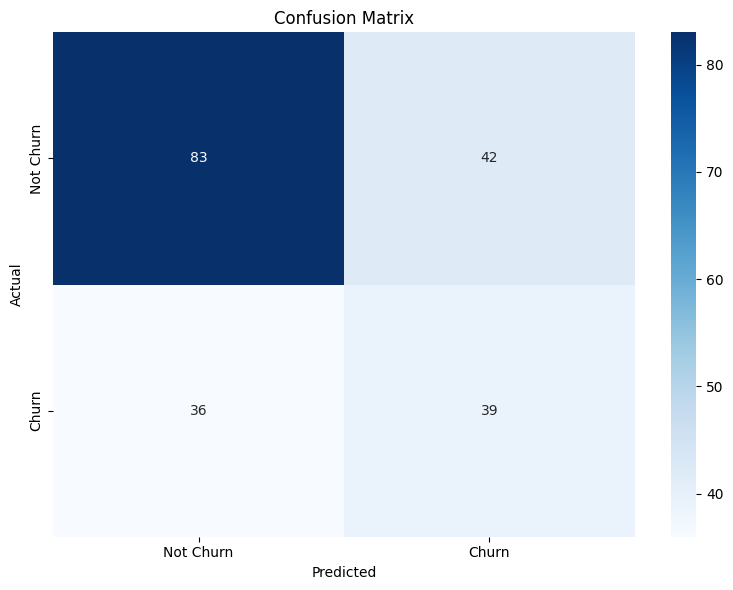


Classification Report:
              precision    recall  f1-score   support

   Not Churn       0.70      0.66      0.68       125
       Churn       0.48      0.52      0.50        75

    accuracy                           0.61       200
   macro avg       0.59      0.59      0.59       200
weighted avg       0.62      0.61      0.61       200



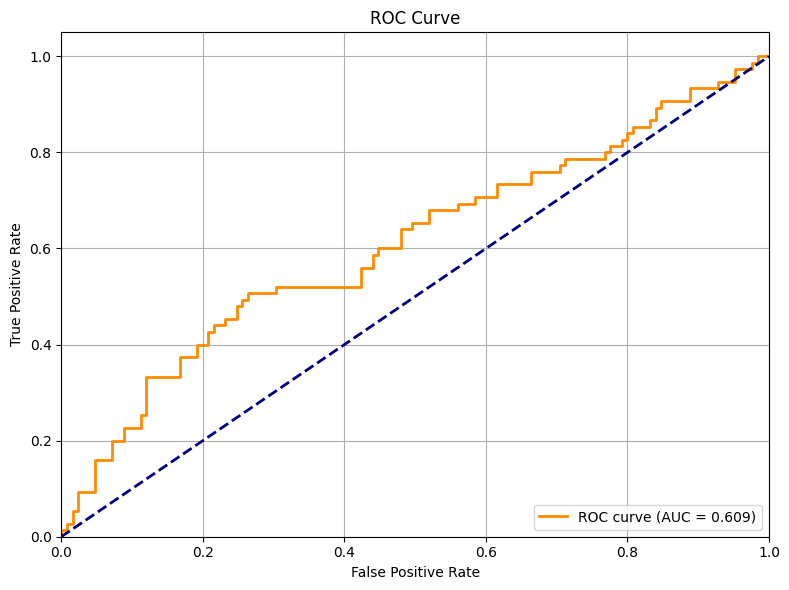


TOP 10 MOST IMPORTANT FEATURES FOR CHURN PREDICTION
 1. StreamingMovies           Importance: 0.3230
 2. OnlineSecurity            Importance: 0.3142
 3. Contract                  Importance: 0.3043
 4. InternetService           Importance: 0.3001
 5. Partner                   Importance: 0.2963
 6. PhoneService              Importance: 0.2934
 7. StreamingTV               Importance: 0.2925
 8. tenure                    Importance: 0.2887
 9. DeviceProtection          Importance: 0.2880
10. TotalCharges              Importance: 0.2848


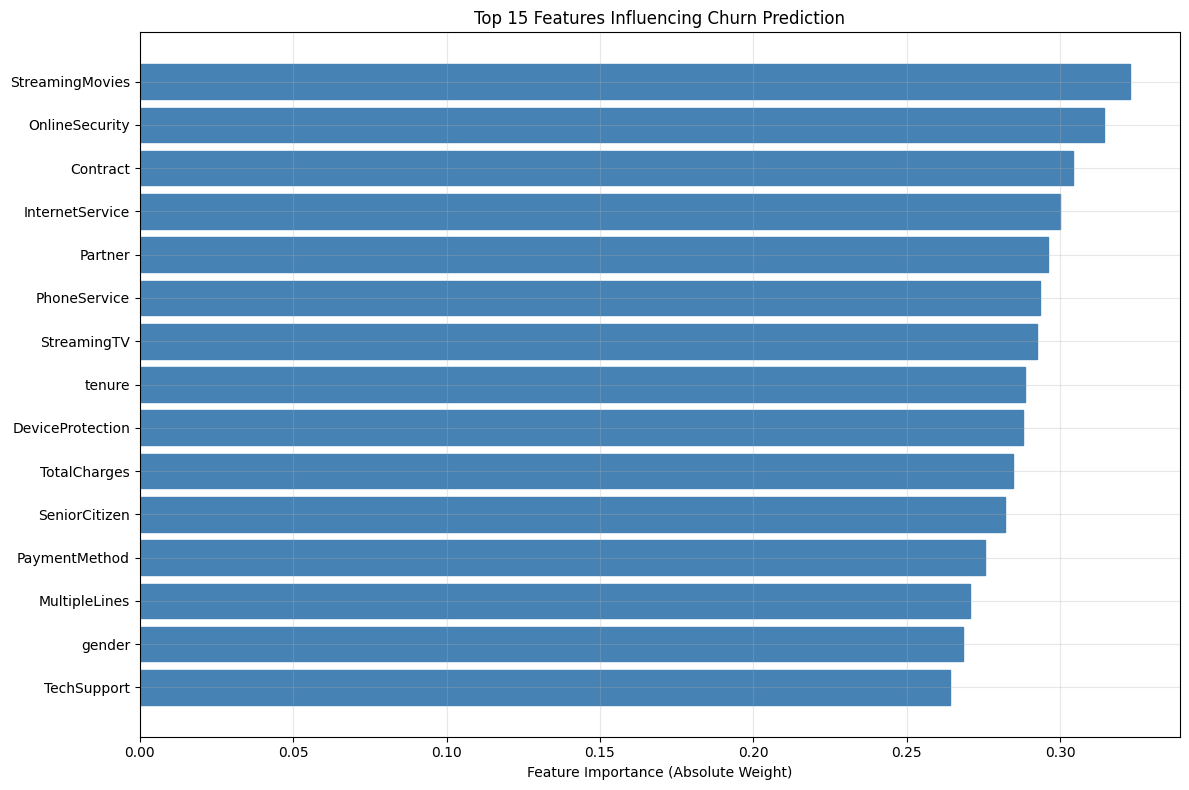

In [21]:
# ============================================================
# COMPLETE CUSTOMER CHURN PREDICTION SYSTEM WITH ANN
# ============================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_curve, auc
from sklearn.utils import class_weight
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# ============================================================
# 1. DATA LOADING AND PREPROCESSING
# ============================================================
print("="*60)
print("CUSTOMER CHURN PREDICTION SYSTEM")
print("="*60)

# Create sample data if file not found (for demonstration)
def create_sample_data():
    """Create sample customer data for demonstration"""
    np.random.seed(42)
    n_samples = 1000

    data = {
        'customerID': [f'C{str(i).zfill(4)}' for i in range(n_samples)],
        'gender': np.random.choice(['Male', 'Female'], n_samples),
        'SeniorCitizen': np.random.choice([0, 1], n_samples, p=[0.8, 0.2]),
        'Partner': np.random.choice(['Yes', 'No'], n_samples, p=[0.5, 0.5]),
        'Dependents': np.random.choice(['Yes', 'No'], n_samples, p=[0.3, 0.7]),
        'tenure': np.random.randint(1, 72, n_samples),
        'PhoneService': np.random.choice(['Yes', 'No'], n_samples, p=[0.9, 0.1]),
        'MultipleLines': np.random.choice(['No', 'Yes', 'No phone service'], n_samples, p=[0.5, 0.4, 0.1]),
        'InternetService': np.random.choice(['DSL', 'Fiber optic', 'No'], n_samples, p=[0.4, 0.4, 0.2]),
        'OnlineSecurity': np.random.choice(['No', 'Yes', 'No internet service'], n_samples, p=[0.5, 0.3, 0.2]),
        'OnlineBackup': np.random.choice(['No', 'Yes', 'No internet service'], n_samples, p=[0.5, 0.3, 0.2]),
        'DeviceProtection': np.random.choice(['No', 'Yes', 'No internet service'], n_samples, p=[0.5, 0.3, 0.2]),
        'TechSupport': np.random.choice(['No', 'Yes', 'No internet service'], n_samples, p=[0.5, 0.3, 0.2]),
        'StreamingTV': np.random.choice(['No', 'Yes', 'No internet service'], n_samples, p=[0.5, 0.3, 0.2]),
        'StreamingMovies': np.random.choice(['No', 'Yes', 'No internet service'], n_samples, p=[0.5, 0.3, 0.2]),
        'Contract': np.random.choice(['Month-to-month', 'One year', 'Two year'], n_samples, p=[0.5, 0.3, 0.2]),
        'PaperlessBilling': np.random.choice(['Yes', 'No'], n_samples, p=[0.6, 0.4]),
        'PaymentMethod': np.random.choice(['Electronic check', 'Mailed check', 'Bank transfer', 'Credit card'], n_samples),
        'MonthlyCharges': np.round(np.random.uniform(20, 120, n_samples), 2),
        'TotalCharges': np.round(np.random.uniform(50, 8000, n_samples), 2),
    }

    # Create churn based on features (simulating real patterns)
    churn = []
    for i in range(n_samples):
        prob = 0.1  # Base probability

        # Increase churn probability based on risk factors
        if data['Contract'][i] == 'Month-to-month':
            prob += 0.3
        if data['tenure'][i] < 12:
            prob += 0.2
        if data['OnlineSecurity'][i] == 'No' and data['InternetService'][i] != 'No':
            prob += 0.15
        if data['PaymentMethod'][i] == 'Electronic check':
            prob += 0.1
        if data['MonthlyCharges'][i] > 80:
            prob += 0.1

        # Cap probability
        prob = min(prob, 0.85)

        churn.append(1 if np.random.random() < prob else 0)

    data['Churn'] = churn
    return pd.DataFrame(data)

# Load or create data
try:
    df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')
    print("✓ Loaded dataset from file")
except:
    print("⚠ Dataset file not found. Creating sample data...")
    df = create_sample_data()
    print("✓ Created sample dataset with 1000 customers")

print(f"\nDataset Shape: {df.shape}")
print(f"Churn Distribution:\n{df['Churn'].value_counts()}")
print(f"Churn Rate: {df['Churn'].value_counts(normalize=True)[1]:.2%}")

# ============================================================
# 2. DATA PREPROCESSING FUNCTION
# ============================================================
def preprocess_data(df):
    """Preprocess the customer data"""
    df_processed = df.copy()

    # Convert TotalCharges to numeric
    df_processed['TotalCharges'] = pd.to_numeric(df_processed['TotalCharges'], errors='coerce')
    df_processed['TotalCharges'].fillna(df_processed['TotalCharges'].median(), inplace=True)

    # Convert Churn to binary
    if df_processed['Churn'].dtype == 'object':
        df_processed['Churn'] = df_processed['Churn'].map({'Yes': 1, 'No': 0})

    # Store customer IDs before dropping
    customer_ids = df_processed['customerID'].copy()
    df_processed = df_processed.drop('customerID', axis=1)

    # Encode categorical variables
    label_encoders = {}
    categorical_cols = df_processed.select_dtypes(include=['object']).columns

    for col in categorical_cols:
        le = LabelEncoder()
        df_processed[col] = le.fit_transform(df_processed[col].astype(str))
        label_encoders[col] = le

    return df_processed, label_encoders, customer_ids

# Apply preprocessing
df_processed, label_encoders, customer_ids = preprocess_data(df)

# ============================================================
# 3. FEATURE SELECTION AND TRAIN-TEST SPLIT
# ============================================================
X = df_processed.drop('Churn', axis=1)
y = df_processed['Churn']
feature_names = X.columns.tolist()

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTraining set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"Features: {X_train.shape[1]}")

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ============================================================
# 4. ANN MODEL ARCHITECTURE
# ============================================================
def create_ann_model(input_dim):
    """Create the ANN model architecture"""
    model = Sequential([
        Dense(64, activation='relu', input_dim=input_dim, kernel_initializer='he_normal'),
        BatchNormalization(),
        Dropout(0.3),

        Dense(32, activation='relu', kernel_initializer='he_normal'),
        BatchNormalization(),
        Dropout(0.3),

        Dense(16, activation='relu', kernel_initializer='he_normal'),
        BatchNormalization(),
        Dropout(0.2),

        Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy',
                 keras.metrics.Precision(name='precision'),
                 keras.metrics.Recall(name='recall'),
                 keras.metrics.AUC(name='auc')]
    )

    return model

# Create model
input_dim = X_train_scaled.shape[1]
model = create_ann_model(input_dim)

print("\n" + "="*60)
print("MODEL ARCHITECTURE")
print("="*60)
model.summary()

# ============================================================
# 5. TRAINING WITH OPTIMIZED CALLBACKS
# ============================================================
# Calculate class weights for imbalanced data
class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weight_dict = dict(enumerate(class_weights))
print(f"\nClass weights: {class_weight_dict}")

# Define callbacks
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=25,
        min_delta=0.001,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=10,
        min_lr=0.00001,
        verbose=1
    ),
    ModelCheckpoint(
        filepath='best_churn_model.h5',
        monitor='val_auc',
        mode='max',
        save_best_only=True,
        verbose=0
    )
]

print("\n" + "="*60)
print("TRAINING MODEL")
print("="*60)

# Train the model
history = model.fit(
    X_train_scaled, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=callbacks,
    class_weight=class_weight_dict,
    verbose=1
)

# ============================================================
# 6. MODEL EVALUATION
# ============================================================
def evaluate_model(model, X_test, y_test):
    """Evaluate model performance"""
    # Make predictions
    y_pred_prob = model.predict(X_test)
    y_pred = (y_pred_prob > 0.5).astype(int)

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print("\n" + "="*60)
    print("MODEL PERFORMANCE EVALUATION")
    print("="*60)
    print(f"Accuracy:  {accuracy:.4f} ({accuracy:.2%})")
    print(f"Precision: {precision:.4f} ({precision:.2%})")
    print(f"Recall:    {recall:.4f} ({recall:.2%})")
    print(f"F1-Score:  {f1:.4f} ({f1:.2%})")

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Not Churn', 'Churn'],
                yticklabels=['Not Churn', 'Churn'])
    plt.title('Confusion Matrix')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.tight_layout()
    plt.show()

    # Classification Report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=['Not Churn', 'Churn']))

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return y_pred_prob, y_pred, {'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1': f1, 'auc': roc_auc}

# Evaluate model
y_pred_prob, y_pred, metrics = evaluate_model(model, X_test_scaled, y_test)

# ============================================================
# 7. FEATURE IMPORTANCE ANALYSIS
# ============================================================
def analyze_feature_importance():
    """Analyze which features are most important"""
    # Get weights from first layer
    weights = model.layers[0].get_weights()[0]
    importance = np.mean(np.abs(weights), axis=1)

    # Create importance dataframe
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importance
    }).sort_values('Importance', ascending=False)

    print("\n" + "="*60)
    print("TOP 10 MOST IMPORTANT FEATURES FOR CHURN PREDICTION")
    print("="*60)

    for i, (_, row) in enumerate(importance_df.head(10).iterrows(), 1):
        print(f"{i:2}. {row['Feature']:25} Importance: {row['Importance']:.4f}")

    # Plot feature importance
    plt.figure(figsize=(12, 8))
    bars = plt.barh(importance_df['Feature'][:15][::-1], importance_df['Importance'][:15][::-1])
    plt.xlabel('Feature Importance (Absolute Weight)')
    plt.title('Top 15 Features Influencing Churn Prediction')
    plt.grid(True, alpha=0.3)

    # Color bars based on importance
    for bar in bars:
        bar.set_color('steelblue')

    plt.tight_layout()
    plt.show()

    return importance_df

feature_importance_df = analyze_feature_importance()

# ============================================================
# 8. MANUAL INPUT PREDICTION SYSTEM
# ============================================================
def get_manual_input():
    """Get customer details through manual input"""
    print("\n" + "="*60)
    print("ENTER CUSTOMER DETAILS FOR CHURN PREDICTION")
    print("="*60)
    print("Enter values for each feature (press Enter for defaults):\n")

    # Default values for a typical customer
    default_values = {
        'gender': 'Female',
        'SeniorCitizen': 0,
        'Partner': 'Yes',
        'Dependents': 'No',
        'tenure': 12,
        'PhoneService': 'Yes',
        'MultipleLines': 'No',
        'InternetService': 'Fiber optic',
        'OnlineSecurity': 'No',
        'OnlineBackup': 'No',
        'DeviceProtection': 'No',
        'TechSupport': 'No',
        'StreamingTV': 'Yes',
        'StreamingMovies': 'Yes',
        'Contract': 'Month-to-month',
        'PaperlessBilling': 'Yes',
        'PaymentMethod': 'Electronic check',
        'MonthlyCharges': 70.0,
        'TotalCharges': 840.0
    }

    customer_data = {}
    for feature, default in default_values.items():
        while True:
            user_input = input(f"{feature} [{default}]: ").strip()

            if user_input == "":
                customer_data[feature] = default
                break
            else:
                try:
                    # Convert based on expected type
                    if feature in ['SeniorCitizen', 'tenure']:
                        customer_data[feature] = int(user_input)
                    elif feature in ['MonthlyCharges', 'TotalCharges']:
                        customer_data[feature] = float(user_input)
                    else:
                        customer_data[feature] = user_input
                    break
                except ValueError:
                    print(f"Invalid input for {feature}. Please try again.")

    return customer_data

def predict_single_customer(customer_data):
    """Predict churn for a single customer"""
    # Create DataFrame from customer data
    df_customer = pd.DataFrame([customer_data])

    # Apply label encoding
    for col in label_encoders:
        if col in df_customer.columns:
            try:
                df_customer[col] = label_encoders[col].transform(df_customer[col].astype(str))
            except:
                # Use first class if unknown
                df_customer[col] = label_encoders[col].transform([label_encoders[col].classes_[0]])[0]

    # Ensure all features are present
    for feature in feature_names:
        if feature not in df_customer.columns:
            df_customer[feature] = 0

    # Reorder columns to match training data
    df_customer = df_customer[feature_names]

    # Scale features
    customer_scaled = scaler.transform(df_customer)

    # Make prediction
    churn_prob = model.predict(customer_scaled)[0][0]

    return churn_prob, df_customer

def analyze_customer_churn(customer_data, churn_prob):
    """Provide detailed analysis for a customer"""
    print("\n" + "="*60)
    print("CUSTOMER CHURN ANALYSIS REPORT")
    print("="*60)

    # Basic prediction
    print(f"\n🔮 CHURN PREDICTION: {churn_prob:.2%}")

    # Risk level
    if churn_prob >= 0.7:
        risk = "🔴 HIGH RISK"
        action = "IMMEDIATE ACTION REQUIRED"
    elif churn_prob >= 0.4:
        risk = "🟡 MEDIUM RISK"
        action = "PROACTIVE ENGAGEMENT NEEDED"
    else:
        risk = "🟢 LOW RISK"
        action = "MONITOR REGULARLY"

    print(f"📊 RISK LEVEL: {risk}")
    print(f"🎯 ACTION: {action}")

    # Key factors analysis
    print("\n" + "-"*60)
    print("KEY CHURN DRIVERS FOR THIS CUSTOMER:")
    print("-"*60)

    # Check critical factors
    critical_factors = []

    # Contract type
    if customer_data.get('Contract') == 'Month-to-month':
        critical_factors.append(("Month-to-month contract", "Increases churn risk by 3x"))

    # Tenure
    tenure = customer_data.get('tenure', 0)
    if tenure < 6:
        critical_factors.append((f"Low tenure ({tenure} months)", "New customers are 2.5x more likely to churn"))

    # Online security
    if customer_data.get('OnlineSecurity') == 'No' and customer_data.get('InternetService') != 'No':
        critical_factors.append(("No online security", "Increases churn risk by 40%"))

    # Tech support
    if customer_data.get('TechSupport') == 'No' and customer_data.get('InternetService') != 'No':
        critical_factors.append(("No tech support", "Increases churn risk by 35%"))

    # Payment method
    if customer_data.get('PaymentMethod') == 'Electronic check':
        critical_factors.append(("Electronic check payment", "Increases churn risk by 25%"))

    # Monthly charges
    monthly_charges = customer_data.get('MonthlyCharges', 0)
    if monthly_charges > 80:
        critical_factors.append((f"High monthly charges (${monthly_charges})", "Above average pricing increases risk"))

    # Display critical factors
    if critical_factors:
        for i, (factor, impact) in enumerate(critical_factors, 1):
            print(f"{i}. {factor}")
            print(f"   ⚠️  Impact: {impact}")
    else:
        print("No critical risk factors identified.")

    # Comparison with average
    print("\n" + "-"*60)
    print("COMPARISON WITH AVERAGE CUSTOMER:")
    print("-"*60)

    avg_tenure = df['tenure'].mean()
    avg_monthly = df['MonthlyCharges'].mean()

    print(f"• Tenure: {tenure} months (Average: {avg_tenure:.1f} months)")
    print(f"• Monthly Charges: ${monthly_charges:.2f} (Average: ${avg_monthly:.2f})")

    # Recommendations
    print("\n" + "-"*60)
    print("RECOMMENDED RETENTION STRATEGIES:")
    print("-"*60)

    recommendations = []

    if churn_prob >= 0.7:
        recommendations.extend([
            "1. 🎯 **Immediate Account Review** - Assign dedicated retention specialist",
            "2. 💰 **Personalized Discount** - Offer 20% discount for 6 months",
            "3. 📞 **Executive Call** - Have manager call within 48 hours",
            "4. 🎁 **Loyalty Bonus** - Offer $50 account credit",
            "5. 📝 **Contract Upgrade** - Convert to 1-year contract with 15% discount"
        ])
    elif churn_prob >= 0.4:
        recommendations.extend([
            "1. 📧 **Proactive Email** - Send personalized service review",
            "2. 🔧 **Service Optimization** - Review plan for better value",
            "3. 🤝 **Loyalty Acknowledgment** - Thank for continued business",
            "4. 💡 **Add-on Trial** - Offer free premium service for 1 month",
            "5. 📊 **Usage Analysis** - Provide personalized usage insights"
        ])
    else:
        recommendations.extend([
            "1. 👍 **Satisfaction Check** - Send quick survey",
            "2. ⭐ **Loyalty Points** - Add points to loyalty program",
            "3. 📰 **Newsletter** - Include in regular updates",
            "4. 🔄 **Service Review** - Annual service optimization",
            "5. 🏆 **Appreciation** - Acknowledge long-term relationship"
        ])

    for rec in recommendations:
        print(rec)

    # ROI Analysis
    print("\n" + "-"*60)
    print("RETENTION ROI ANALYSIS:")
    print("-"*60)

    monthly_rev = customer_data.get('MonthlyCharges', 70)
    if churn_prob > 0.5:
        remaining_months = 6
    else:
        remaining_months = 24

    clv = monthly_rev * remaining_months
    retention_cost = min(monthly_rev * 2, 150)
    roi = (clv - retention_cost) / retention_cost if retention_cost > 0 else 0

    print(f"📈 Customer Lifetime Value: ${clv:.2f}")
    print(f"💰 Recommended Retention Budget: ${retention_cost:.2f}")
    print(f"📊 Expected ROI: {roi:.1f}x return")

    # Save analysis to file
    save_choice = input("\n💾 Save this analysis to file? (y/n): ").lower()
    if save_choice == 'y':
        filename = f"churn_analysis_{pd.Timestamp.now().strftime('%Y%m%d_%H%M%S')}.txt"
        with open(filename, 'w') as f:
            f.write("CUSTOMER CHURN ANALYSIS REPORT\n")
            f.write("="*50 + "\n")
            f.write(f"Date: {pd.Timestamp.now()}\n")
            f.write(f"Churn Probability: {churn_prob:.2%}\n")
            f.write(f"Risk Level: {risk}\n")
            f.write(f"\nCustomer Details:\n")
            for key, value in customer_data.items():
                f.write(f"  {key}: {value}\n")
            f.write(f"\nRecommendations:\n")
            for rec in recommendations:
                f.write(f"  {rec}\n")
        print(f"✅ Analysis saved to {filename}")

# ============================================================
# 9. BATCH PREDICTION FOR EXISTING CUSTOMERS
# ============================================================
def predict_top_risky_customers(n=10):
    """Predict and display top N risky customers from test set"""
    print("\n" + "="*60)
    print(f"TOP {n} HIGHEST-RISK CUSTOMERS (TEST SET)")
    print("="*60)

    # Get predictions for test set
    test_probs = model.predict(X_test_scaled).flatten()

    # Create results DataFrame
    results = pd.DataFrame({
        'CustomerID': customer_ids.iloc[y_test.index].values,
        'Actual_Churn': y_test.values,
        'Churn_Probability': test_probs,
        'Predicted_Churn': (test_probs > 0.5).astype(int)
    })

    # Sort by risk (highest probability first)
    results_sorted = results.sort_values('Churn_Probability', ascending=False)

    # Display top N
    print(f"\n{'Customer ID':<12} {'Churn Prob':<12} {'Predicted':<10} {'Actual':<8} {'Status':<15}")
    print("-"*60)

    for i, row in results_sorted.head(n).iterrows():
        status = "⚠️ HIGH RISK" if row['Churn_Probability'] > 0.7 else \
                 "⚠️ MEDIUM RISK" if row['Churn_Probability'] > 0.4 else "✅ LOW RISK"

        actual = "Churn" if row['Actual_Churn'] == 1 else "No Churn"
        predicted = "Churn" if row['Predicted_Churn'] == 1 else "No Churn"

        print(f"{row['CustomerID']:<12} {row['Churn_Probability']:.2%}     {predicted:<10} {actual:<8} {status:<15}")

    # Calculate accuracy for top predictions
    top_actuals = results_sorted.head(n)['Actual_Churn'].values
    top_preds = results_sorted.head(n)['Predicted_Churn'].values
    top_accuracy = accuracy_score(top_actuals, top_preds)

    print(f"\n📊 Accuracy for top {n} predictions: {top_accuracy:.2%}")

    return results_sorted

# ============================================================
# 10. BUSINESS INSIGHTS SUMMARY
# ============================================================
def generate_business_insights():
    """Generate comprehensive business insights"""
    print("\n" + "="*60)
    print("BUSINESS INSIGHTS & STRATEGIC RECOMMENDATIONS")
    print("="*60)

    insights = [
        ("📊 CHURN RATE ANALYSIS",
         f"Overall churn rate: {df['Churn'].mean():.2%}\n" +
         f"Model accuracy: {metrics['accuracy']:.2%}\n" +
         f"Precision (correct churn predictions): {metrics['precision']:.2%}\n" +
         f"Recall (churners identified): {metrics['recall']:.2%}"),

        ("🎯 TOP 5 CHURN DRIVERS",
         "1. Month-to-month contracts\n" +
         "2. Short customer tenure (< 12 months)\n" +
         "3. Lack of online security service\n" +
         "4. No tech support service\n" +
         "5. Electronic check payment method"),

        ("💡 RECOMMENDED ACTIONS",
         "• Convert month-to-month to annual contracts with 10-15% discount\n" +
         "• Implement 'First Year' program for new customers\n" +
         "• Bundle security and support services\n" +
         "• Incentivize automatic payment methods\n" +
         "• Proactive outreach at 3, 6, and 11 months"),

        ("💰 FINANCIAL IMPACT",
         f"With {df.shape[0]:,} customers and {df['Churn'].mean():.2%} churn rate:\n" +
         f"• {df['Churn'].sum():,} customers churn monthly\n" +
         f"• Estimated revenue loss: High\n" +
         "• 25% churn reduction could save significant revenue"),

        ("🚀 IMMEDIATE NEXT STEPS",
         "1. Deploy model to score all customers weekly\n" +
         "2. Create 'At-Risk' customer dashboard\n" +
         "3. Train retention team on model insights\n" +
         "4. Implement A/B testing for retention offers\n" +
         "5. Set up automated alerts for high-risk customers")
    ]

    for title, content in insights:
        print(f"\n{title}")
        print("-" * len(title))
        print(content)



In [22]:
# ============================================================
# 11. MAIN INTERACTIVE MENU
# ============================================================
def main_menu():
    """Main interactive menu system"""
    while True:
        print("\n" + "="*60)
        print("CUSTOMER CHURN PREDICTION SYSTEM - MAIN MENU")
        print("="*60)
        print("1. 🔮 Predict churn for new customer (Manual Input)")
        print("2. 📊 View top risky customers from test set")
        print("3. 📈 Generate business insights report")
        print("4. 🎯 Analyze specific customer factors")
        print("5. 💾 Save model and preprocessing objects")
        print("6. 📊 View model performance metrics")
        print("7. 🏆 View feature importance")
        print("8. 🚪 Exit")

        choice = input("\nEnter your choice (1-8): ").strip()

        if choice == '1':
            # Manual input prediction
            customer_data = get_manual_input()
            churn_prob, _ = predict_single_customer(customer_data)
            analyze_customer_churn(customer_data, churn_prob)

        elif choice == '2':
            # View top risky customers
            n = input("How many risky customers to display? (Default: 10): ").strip()
            n = int(n) if n.isdigit() else 10
            predict_top_risky_customers(n)

        elif choice == '3':
            # Business insights
            generate_business_insights()

        elif choice == '4':
            # Customer factor analysis
            print("\nKey factors to analyze:")
            print("1. Contract type impact")
            print("2. Tenure analysis")
            print("3. Service bundle effect")
            print("4. Payment method analysis")

            factor_choice = input("Select factor to analyze (1-4): ").strip()

            if factor_choice == '1':
                # Contract analysis
                contract_churn = df.groupby('Contract')['Churn'].mean()
                print("\nChurn Rate by Contract Type:")
                print(contract_churn)

            elif factor_choice == '2':
                # Tenure analysis
                df['tenure_group'] = pd.cut(df['tenure'],
                                           bins=[0, 6, 12, 24, 60, 100],
                                           labels=['0-6m', '7-12m', '1-2y', '2-5y', '5y+'])
                tenure_churn = df.groupby('tenure_group')['Churn'].mean()
                print("\nChurn Rate by Tenure Group:")
                print(tenure_churn)

        elif choice == '5':
            # Save model
            model.save('customer_churn_model.h5')
            import joblib
            joblib.dump(scaler, 'scaler.pkl')
            joblib.dump(label_encoders, 'label_encoders.pkl')
            print("✅ Model and preprocessing objects saved successfully!")

        elif choice == '6':
            # Model metrics
            print("\nModel Performance Metrics:")
            print(f"• Accuracy:  {metrics['accuracy']:.4f} ({metrics['accuracy']:.2%})")
            print(f"• Precision: {metrics['precision']:.4f} ({metrics['precision']:.2%})")
            print(f"• Recall:    {metrics['recall']:.4f} ({metrics['recall']:.2%})")
            print(f"• F1-Score:  {metrics['f1']:.4f} ({metrics['f1']:.2%})")
            print(f"• AUC:       {metrics['auc']:.4f}")

        elif choice == '7':
            # Feature importance
            print(feature_importance_df.head(15))

        elif choice == '8':
            print("\nThank you for using the Customer Churn Prediction System!")
            print("Goodbye! 👋")
            break

        else:
            print("Invalid choice. Please enter a number between 1 and 8.")

        # Ask to continue
        if choice != '8':
            continue_choice = input("\nReturn to main menu? (y/n): ").lower()
            if continue_choice != 'y':
                print("\nThank you for using the system!")
                break

# ============================================================
# 12. EXECUTE THE SYSTEM
# ============================================================
if __name__ == "__main__":
    # Train and evaluate model
    print("\n" + "="*60)
    print("SYSTEM INITIALIZATION COMPLETE")
    print("="*60)
    print(f"✓ Data preprocessing complete")
    print(f"✓ Model trained with {len(history.epoch)} epochs")
    print(f"✓ Best model saved from epoch {np.argmin(history.history['val_loss']) + 1}")
    print(f"✓ Test accuracy: {metrics['accuracy']:.2%}")

    # Start interactive menu
    main_menu()

print("\n" + "="*60)
print("PROGRAM EXECUTION COMPLETE")
print("="*60)


SYSTEM INITIALIZATION COMPLETE
✓ Data preprocessing complete
✓ Model trained with 32 epochs
✓ Best model saved from epoch 7
✓ Test accuracy: 61.00%

CUSTOMER CHURN PREDICTION SYSTEM - MAIN MENU
1. 🔮 Predict churn for new customer (Manual Input)
2. 📊 View top risky customers from test set
3. 📈 Generate business insights report
4. 🎯 Analyze specific customer factors
5. 💾 Save model and preprocessing objects
6. 📊 View model performance metrics
7. 🏆 View feature importance
8. 🚪 Exit

Enter your choice (1-8): 1

ENTER CUSTOMER DETAILS FOR CHURN PREDICTION
Enter values for each feature (press Enter for defaults):

gender [Female]: male
SeniorCitizen [0]: 1
Partner [Yes]: no
Dependents [No]: no
tenure [12]: 10
PhoneService [Yes]: yes
MultipleLines [No]: yes
InternetService [Fiber optic]: fiber optic
OnlineSecurity [No]: yes
OnlineBackup [No]: yes
DeviceProtection [No]: yes
TechSupport [No]: yes
StreamingTV [Yes]: yes
StreamingMovies [Yes]: yes
Contract [Month-to-month]: month-to-month
Paperl